# Data Context

For my thesis on energy demand forecasting (EDF) in the Netherlands, I need both data on the predictors (weather related, NAO index, energy price, renewable energy consumption) and data on the target variable (energy consumption). I acquired my data from various data sources. Below I share an overview of the data sources.

|Data                |Granularity |Year range|Source |
|--------------------|------------|----------|-------|
|Load consumption    |hourly      |2021-2023 |ENTSO-E|
|Weather             |hourly/daily|1901-2024 |KNMI   |
|NAO index           |monthly     |1950-2023 |NAO    |
|Energy price        |monthly     |2018-2023 |CBS    |
|Renewable energy    |yearly      |2015-2022 |CBS    |

KNMI is the Dutch weather institute and provides various data sets on weather-related topics online. I used a dataset with data from their weather station in De Bilt as it is the most central weather station of the Netherlands and is seen as the average of the Netherlands. 

# Data Description

I start with loading the datasets and doing some preprocessing to get it in the right shape (e.g. casting date columns, etc.).

In [1]:
# imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import warnings
import math
from math import sqrt
import time
warnings.filterwarnings("ignore")

## 1. Load consumption data

We have three datasets of the load data, each for a different year. We read the csvs and add them together into one big dataset. Furthermore, we filter on the Dutch data only as the dataset also contains data on other countries. We select the needed columns and cast the date columns. 

There were originally two columns with load in the dataset: Value and Value_ScaleTo100. We checked and these were always equal so we just chose one of them to keep in the dataset.

In [2]:
def preprocess_load_consumption(path2021: str, path2022: str, path2023: str) -> pd.DataFrame:
    """
    Read data and concat the datasets.
    Filter on CountryCode NL only and reset index after filtering.
    Cast date and date UTC column and add hour column.
    Create a week key combining year and week number.
    Rename the Value (load) column to LoadConsumption.
    """
    load_2021 = pd.read_csv(path2021, delimiter=';')
    load_2022 = pd.read_csv(path2022, delimiter=';')
    load_2023 = pd.read_csv(path2023)

    load = pd.concat([load_2021, load_2022, load_2023])

    load_NL = load[load['CountryCode'] == 'NL']
    load_NL.reset_index(drop=True, inplace=True)

    load_NL = load_NL[['DateUTC', 'DateShort', 'Cov_ratio', 'Value', 'Value_ScaleTo100']]

    load_NL['Date'] = pd.to_datetime(load_NL['DateShort'], dayfirst=True, format='%d/%m/%Y')
    load_NL['DateUTC'] = pd.to_datetime(load_NL['DateUTC'], format='%d/%m/%Y %H:%M')
    load_NL['Hour'] = load_NL['DateUTC'].dt.hour + 1
    load_NL['Year'] = load_NL['Date'].dt.year
    load_NL['Week'] = load_NL['Date'].dt.isocalendar().week

    load_NL['WeekKey'] = load_NL['Year'].astype(str) + load_NL['Week'].apply(lambda x: '{:02d}'.format(x))
    load_NL['day_of_week'] = load_NL['Date'].dt.day_name()

    load_NL.rename(columns={'Value': 'LoadConsumption'}, inplace=True)

    load_NL.drop(columns=['Cov_ratio', 'Value_ScaleTo100'], inplace=True)

    return load_NL

In [3]:
path2021 = '../Data/load/monthly_hourly_load_values_2021.csv'
path2022 = '../Data/load/monthly_hourly_load_values_2022.csv'
path2023 = '../Data/load/monthly_hourly_load_values_2023.csv'

load_NL = preprocess_load_consumption(path2021, path2022, path2023)

load_NL

,DateUTC,DateShort,LoadConsumption,Date,Hour,Year,Week,WeekKey,day_of_week
0,2021-01-01 00:00:00,01/01/2021,11313.1375,2021-01-01,1,2021,53,202153,Friday
1,2021-01-01 01:00:00,01/01/2021,10925.1475,2021-01-01,2,2021,53,202153,Friday
2,2021-01-01 02:00:00,01/01/2021,10576.8200,2021-01-01,3,2021,53,202153,Friday
3,2021-01-01 03:00:00,01/01/2021,10371.1225,2021-01-01,4,2021,53,202153,Friday
4,2021-01-01 04:00:00,01/01/2021,10420.2075,2021-01-01,5,2021,53,202153,Friday
...,...,...,...,...,...,...,...,...,...
24067,2023-09-30 19:00:00,30/09/2023,12210.0050,2023-09-30,20,2023,39,202339,Saturday
24068,2023-09-30 20:00:00,30/09/2023,11532.9300,2023-09-30,21,2023,39,202339,Saturday
24069,2023-09-30 21:00:00,30/09/2023,10355.4475,2023-09-30,22,2023,39,202339,Saturday
24070,2023-09-30 22:00:00,30/09/2023,9813.3175,2023-09-30,23,2023,39,202339,Saturday


Normality of the data

In [4]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import shapiro

def check_normality(df, feature):
    plt.figure(figsize=(6, 6))

    # histogram
    plt.hist(df[feature], edgecolor='black', bins=20)
    plt.title(f'Histogram of {feature}')

    # qq plot
    sm.qqplot(df[feature], line='45')
    plt.title(f'QQ plot of {feature}')

    plt.tight_layout()

    plt.show()

    # shapiro wilk
    print(shapiro(df[feature]))


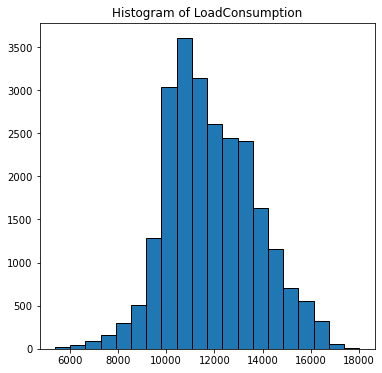

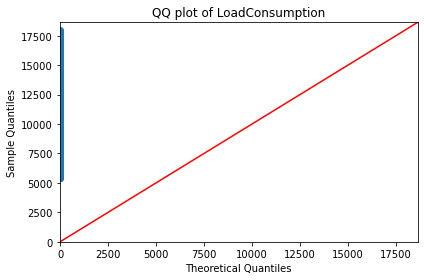

ShapiroResult(statistic=0.9893758893013, pvalue=3.405341360745368e-38)


In [5]:
check_normality(df=load_NL, feature='LoadConsumption')

Nulls in the load consumption data

In [6]:
load_NL.isna().sum() / len(load_NL)

DateUTC            0.0
DateShort          0.0
LoadConsumption    0.0
Date               0.0
Hour               0.0
Year               0.0
Week               0.0
WeekKey            0.0
day_of_week        0.0
dtype: float64

We can see that there are no nulls in the data. Also, we can see that the data is not normally distributed. This is suggested by the histogram which is slightly bigger on the right, the QQ plot shows that the points aren't on the diagonal line and finally, the Shapiro test shows that the data is not normal distributed with a p-value of almost 0. 

## 2. KNMI weather data

The KNMI dataset contains lots of weather related variables. The column names are abbreviations, which we replace with full names. We select data from 2021 and on because that is the start date of our research. We cast some columns to the right format.

We choose these predictors from the dataset

|Abbreviation|Full name                 |Description                                                       |
|------------|--------------------------|------------------------------------------------------------------|
|YYYYMMDD    |Date                      | Date (YYYY=year MM=month DD=day)                                 |
|RH          |DailyPrecipitation        | Daily precipitation amount (in 0.1 mm) (-1 for <0.05 mm)         |
|RHX         |MaxHourlyPrecipitation    | Maximum hourly precipitation amount (in 0.1 mm) (-1 for <0.05 mm)|
|RHXH        |HDMaxPrecipitation*       | Hourly division in which RHX was measured                        |
|TG          |DailyMeanTemperature      | Daily mean temperature in (0.1 degrees Celsius)                  |
|TN          |HourlyMinTemperature      | Minimum temperature (in 0.1 degrees Celsius)                     |
|TNH         |HDMinTemperature*         | Hourly division in which TN was measured                         |
|TX          |HourlyMaxTemperature      | Maximum temperature (in 0.1 degrees Celsius)                     |
|TXH         |HDMaxTemperature*         | Hourly division in which TX was measured                         |
|FG          |DailyMeanWindspeed        | Daily mean windspeed (in 0.1 m/s)                                |
|FHN         |HourlyMinMeanWindspeed    | Minimum hourly mean windspeed (in 0.1 m/s)                       |
|FHNH        |HDMinMeanWindspeed*       | Hourly division in which FHN was measured                        |
|FHX         |HourlyMaxMeanWindspeed    | Maximum hourly mean windspeed (in 0.1 m/s)                       |
|FHXH        |HDMaxMeanWindspeed*       | Hourly division in which FHX was measured                        |

Where * HD = Hourly Division

In [7]:
def read_data(path: str) -> pd.DataFrame:
    """
    Read the data.
    Strip spaces from the columns.
    Rename all the columns (abbreviations -> full names).
    """

    weather = pd.read_csv(path)

    weather.columns = weather.columns.str.strip()
    weather = weather.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    weather.replace('', None, inplace=True)

    column_mapping = {
        'YYYYMMDD': 'Date',
        'RH': 'DailyPrecipitation',
        'RHX': 'MaxHourlyPrecipitation',
        'RHXH': 'HDMaxPrecipitation',
        'TG': 'DailyMeanTemperature',
        'TN': 'HourlyMinTemperature',
        'TNH': 'HDMinTemperature',
        'TX': 'HourlyMaxTemperature',
        'TXH': 'HDMaxTemperature',
        'FG': 'DailyMeanWindspeed',
        'FHX': 'MaxHourlyMeanWindspeed',
        'FHXH': 'HDMaxMeanWindspeed',
        'FHN': 'MinHourlyMeanWindspeed',
        'FHNH': 'HDMinMeanWindspeed'
    }

    weather = weather[column_mapping.keys()]
    weather.rename(columns=column_mapping, inplace=True)

    return weather


def filter_on_year(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Filter on only 2021 and later and reset index after filtering.
    """
    weather = weather[weather['Date'] >= 20210101]
    weather.reset_index(drop=True, inplace=True)

    return weather


def cast_datekey(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Cast datekey 20210101 to format 2021/01/01
    """
    weather['Date'] = pd.to_datetime(weather['Date'], format='%Y%m%d').dt.strftime('%Y/%m/%d')

    return weather


def cast_hour_columns(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Cast hour columns to integer.
    """
    hour_cols = [
        'HDMaxPrecipitation',
        'HDMinTemperature',
        'HDMaxTemperature',
        'HDMaxMeanWindspeed',
        'HDMinMeanWindspeed'
    ]

    for i in hour_cols:
        weather[i] = weather[i].astype(int)

    return weather


def convert_columns(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Divide the following columns by 10 to get actual number, since they are 0.1 of the actual number.
    """
    cols_to_convert = [
        'DailyPrecipitation',
        'MaxHourlyPrecipitation',
        'DailyMeanTemperature',
        'HourlyMaxTemperature',
        'DailyMeanWindspeed',
        'MinHourlyMeanWindspeed',
        'MaxHourlyMeanWindspeed'
    ]
    for i in cols_to_convert:
        weather[i] = weather[i] / 10

    return weather


def create_date_columns(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Cast date column (2021-01-01 instead of 2021/01/01) and add month and year columns
    Create a week key combining year and week number
    """
    weather['Date'] = pd.to_datetime(weather['Date'], format='%Y/%m/%d')
    weather['Month'] = weather['Date'].dt.month
    weather['Year'] = weather['Date'].dt.year
    weather['Week'] = weather['Date'].dt.isocalendar().week

    weather['WeekKey'] = weather['Year'].astype(str) + weather['Week'].apply(lambda x: '{:02d}'.format(x))
    weather['day_of_week'] = weather['Date'].dt.day_name()

    return weather


def preprocess_weather(path: str) -> pd.DataFrame:
    """
    Preprocess the weather data.
    """
    weather = read_data(path)
    weather = filter_on_year(weather)
    weather = cast_datekey(weather)
    weather = cast_hour_columns(weather)
    weather = convert_columns(weather)
    weather = create_date_columns(weather)

    return weather

In [8]:
weather_path = '../Data/hourly weather data knmi.txt'

weather = preprocess_weather(weather_path)

weather

,Date,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,DailyMeanWindspeed,MaxHourlyMeanWindspeed,HDMaxMeanWindspeed,MinHourlyMeanWindspeed,HDMinMeanWindspeed,Month,Year,Week,WeekKey,day_of_week
0,2021-01-01,0.0,0.0,1,3.0,-35,3,5.7,14,2.1,3.0,6,1.0,1,1,2021,53,202153,Friday
1,2021-01-02,0.3,0.1,9,3.6,31,8,4.5,1,1.8,3.0,1,1.0,14,1,2021,53,202153,Saturday
2,2021-01-03,0.1,0.1,23,3.3,28,7,4.0,14,3.5,5.0,15,2.0,1,1,2021,53,202153,Sunday
3,2021-01-04,1.1,0.6,3,2.8,23,23,3.6,10,5.3,6.0,10,5.0,1,1,2021,1,202101,Monday
4,2021-01-05,0.1,0.1,8,2.9,21,2,3.6,20,4.1,5.0,1,3.0,9,1,2021,1,202101,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,2024-01-06,-0.1,-0.1,1,3.2,7,24,5.1,1,4.0,5.0,17,3.0,1,1,2024,1,202401,Saturday
1101,2024-01-07,-0.1,-0.1,1,-0.2,-20,22,1.4,14,4.4,6.0,12,3.0,1,1,2024,1,202401,Sunday
1102,2024-01-08,-0.1,-0.1,1,-1.8,-32,24,0.5,14,5.3,7.0,14,3.0,5,1,2024,2,202402,Monday
1103,2024-01-09,0.0,0.0,1,-3.2,-56,8,0.1,14,4.6,6.0,11,3.0,22,1,2024,2,202402,Tuesday


In [9]:
weather.isna().sum() / len(load_NL)

Date                      0.0
DailyPrecipitation        0.0
MaxHourlyPrecipitation    0.0
HDMaxPrecipitation        0.0
DailyMeanTemperature      0.0
HourlyMinTemperature      0.0
HDMinTemperature          0.0
HourlyMaxTemperature      0.0
HDMaxTemperature          0.0
DailyMeanWindspeed        0.0
MaxHourlyMeanWindspeed    0.0
HDMaxMeanWindspeed        0.0
MinHourlyMeanWindspeed    0.0
HDMinMeanWindspeed        0.0
Month                     0.0
Year                      0.0
Week                      0.0
WeekKey                   0.0
day_of_week               0.0
dtype: float64

We see no nulls in the weather data.

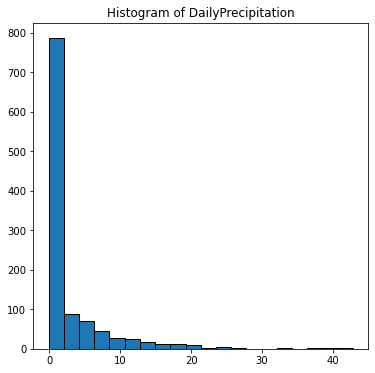

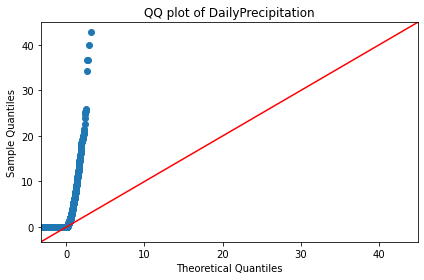

ShapiroResult(statistic=0.5855373740196228, pvalue=2.802596928649634e-45)


In [10]:
check_normality(df=weather, feature='DailyPrecipitation')

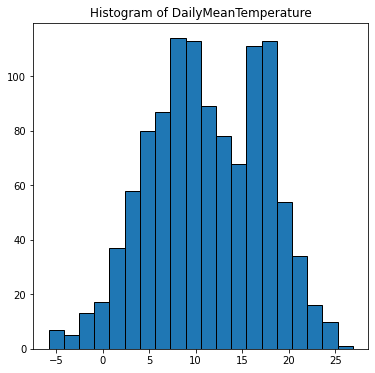

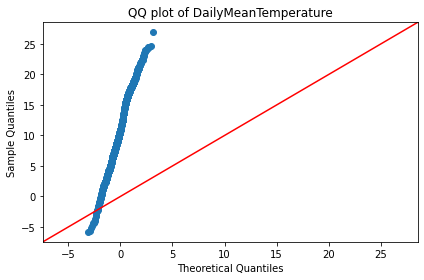

ShapiroResult(statistic=0.9880631566047668, pvalue=7.790288947262525e-08)


In [11]:
check_normality(df=weather, feature='DailyMeanTemperature')

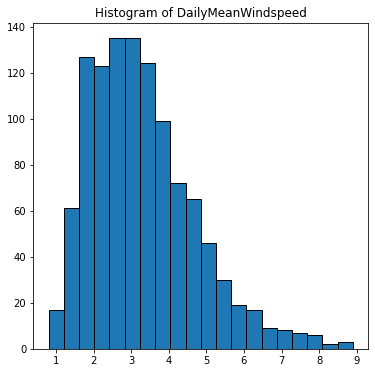

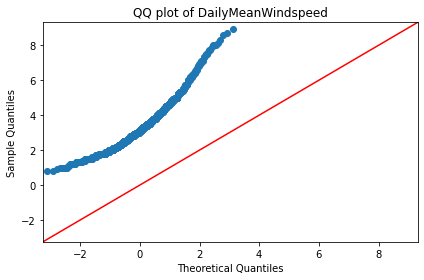

ShapiroResult(statistic=0.946213960647583, pvalue=1.25159858380089e-19)


In [12]:
check_normality(df=weather, feature='DailyMeanWindspeed')

We checked the normality of various features in the weather data and see that they are not normal distributed. 

## 3. NAO index

The NAO index dataset contains data from 1950 and on. It has a row for each year, where the columns are the 12 months. We melt the dataset because we want a Year-Month combination on each row. 

In [13]:
def preprocess_nao(path: str) -> pd.DataFrame:
    """
    Reset index, index is now the year and we want this as a column.
    Melt the dataset into a year, month and NAO column.
    Rename index to Year.
    Map the months (now strings) to corresponding month numbers.
    """
    nao = pd.read_csv(path, delim_whitespace=True, index_col=0)
    nao.reset_index(inplace=True)
    nao_melted = pd.melt(nao, id_vars=['index'], var_name='Month', value_name='NAO')
    nao_melted.rename(columns={'index':'Year'}, inplace=True)
    month_mapping = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    nao_melted['Month'] = nao_melted['Month'].map(month_mapping)

    return nao_melted

In [14]:
NAO_file_path = '../Data/norm.nao.monthly.b5001.current.ascii.table.txt'

nao = preprocess_nao(NAO_file_path)

nao

,Year,Month,NAO
0,1950,1,0.92
1,1951,1,0.08
2,1952,1,0.93
3,1953,1,0.33
4,1954,1,0.37
...,...,...,...
883,2019,12,1.20
884,2020,12,-0.30
885,2021,12,0.29
886,2022,12,-0.15


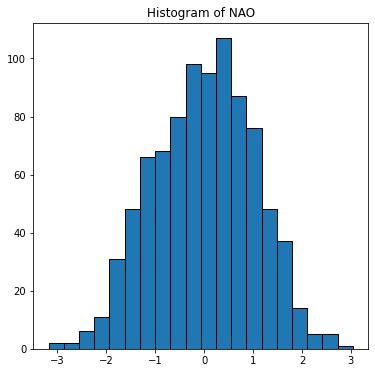

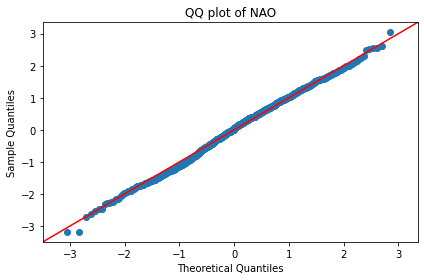

ShapiroResult(statistic=nan, pvalue=1.0)


In [15]:
check_normality(df=nao, feature='NAO')

The NAO index data seems to be normal distributed.

In [16]:
nao.isna().sum() / len(nao)

Year     0.000000
Month    0.000000
NAO      0.001126
dtype: float64

Only the last value of the nao index data is NaN. This is caused by the data not being available yet.

## 4. Energy price

In [17]:
def ingest_energy_prices(energy_prices_path: str) -> pd.DataFrame:
    """
    Read data.
    Rename columns to incl and excl btw.
    Remove first to rows.
    """

    # read
    energy_prices = pd.read_csv(energy_prices_path, delimiter=';')

    # rename ex and incl btw columns
    all_cols = energy_prices.columns
    ex_btw_cols = [col for col in all_cols if col.endswith('.1')]
    incl_btw_cols = set(all_cols) - set(ex_btw_cols)

    energy_prices.rename(columns=lambda x: x.replace('.1', '_ex_btw'), inplace=True)

    energy_prices.rename(
        columns={col: col + '_incl_btw' for col in incl_btw_cols},
        inplace=True
    )

    # replace weird characters
    energy_prices.rename(columns=lambda x: x.replace('|', '_'), inplace=True)
    energy_prices.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

    # filter out other rows
    energy_prices = (
        energy_prices[~energy_prices['Onderwerp_incl_btw'].isin(["Btw", "Perioden"])]
        .reset_index()
        .drop('index', axis=1)
    )

    return energy_prices


def drop_years(energy_prices: pd.DataFrame) -> pd.DataFrame:
    """
    The Onderwerp_incl_btw columns contains months and years,
    e.g. 2018 januari. It also sometimes contains just the year.
    We delete these rows.
    """

    unique_values = energy_prices['Onderwerp_incl_btw'].unique()
    values_to_select = [i for i in unique_values if (len(i) > 4)]

    energy_prices = energy_prices[energy_prices['Onderwerp_incl_btw'].isin(values_to_select)]

    return energy_prices


def cast_year_month_col(energy_prices: pd.DataFrame) -> pd.DataFrame:
    """
    Cast year month col
    Also filter out 2023, because data is not up to date for this year yet.
    """

    month_mapping = {'januari': "01", 'februari': "02", 'maart': "03",
                     'april': "04", 'mei': "05", 'juni': "06",
                     'juli': "07", 'augustus': "08", 'september': "09",
                     'oktober': "10", 'november': "11", 'december': "12"}

    energy_prices['Year'] = energy_prices['Onderwerp_incl_btw'].apply(lambda x: x.split(' ')[0])
    energy_prices['Month'] = energy_prices['Onderwerp_incl_btw'].apply(lambda x: x.split(' ')[1])
    energy_prices['Month'] = energy_prices['Month'].map(month_mapping)

    energy_prices['MonthYear'] = energy_prices['Year'] + energy_prices['Month']
    energy_prices['MonthYear'] = energy_prices['MonthYear'].astype(int)

    energy_prices.drop('Onderwerp_incl_btw', axis=1, inplace=True)
    energy_prices.set_index('MonthYear', inplace=True)
    return energy_prices


def cast_cols_to_decimal(energy_prices: pd.DataFrame) -> pd.DataFrame:
    """
    Cast all columns to decimals.
    """

    for i in energy_prices.columns:
        energy_prices[i] = energy_prices[i].str.replace(',', '.')
        energy_prices[i] = energy_prices[i].astype(float)

    return energy_prices


def select_columns(energy_prices: pd.DataFrame) -> pd.DataFrame:
    """Select only the columns we wish to keep."""
    cols_to_select = [
       'Aardgas_Vast_leveringstarief_incl_btw',
       'Aardgas_Vast_leveringstarief_ex_btw',
       'Aardgas_Variabel_leveringstarief_incl_btw',
       'Aardgas_Variabel_leveringstarief_ex_btw',
       'Elektriciteit_Vast_leveringstarief_incl_btw',
       'Elektriciteit_Vast_leveringstarief_ex_btw',
       'Elektriciteit_Variabel_leveringstarief_incl_btw',
       'Elektriciteit_Variabel_leveringstarief_ex_btw',
       'Year', 'Month']
    
    energy_prices = energy_prices[cols_to_select]
    return energy_prices

def preprocess_energy_price(energy_prices_path: str) -> pd.DataFrame:
    energy_prices_ingested = ingest_energy_prices(energy_prices_path)
    energy_prices_filtered = drop_years(energy_prices_ingested)
    energy_prices_month_year = cast_year_month_col(energy_prices_filtered)
    energy_prices_casted = cast_cols_to_decimal(energy_prices_month_year)
    energy_prices_selected = select_columns(energy_prices_casted)
    return energy_prices_selected

In [18]:
energy_prices_path = '../Data/Gemiddelde_energietarieven_voor_consumenten__2018___2023_29112023_204634.csv'

energy_prices = preprocess_energy_price(energy_prices_path)

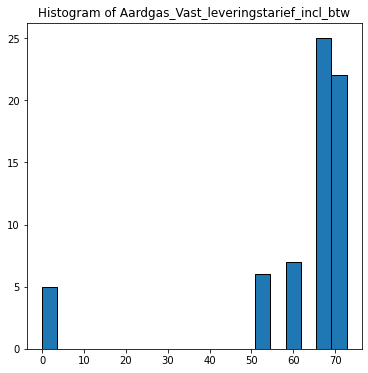

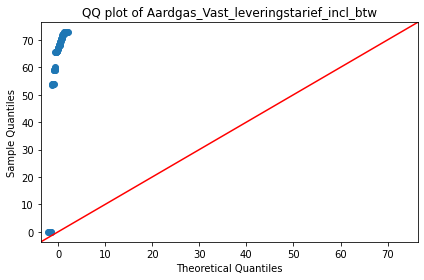

ShapiroResult(statistic=0.5448513031005859, pvalue=6.853185553767904e-13)


In [19]:
check_normality(df=energy_prices, feature='Aardgas_Vast_leveringstarief_incl_btw')

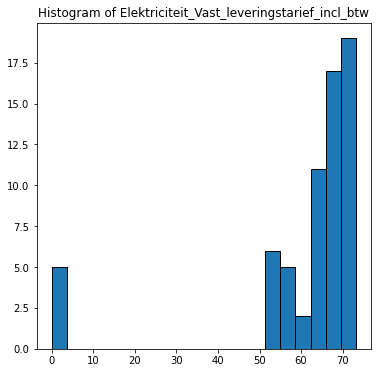

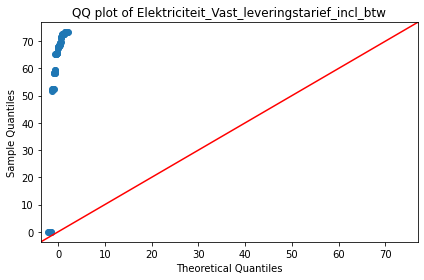

ShapiroResult(statistic=0.5690897703170776, pvalue=1.6018675101647784e-12)


In [20]:
check_normality(df=energy_prices, feature='Elektriciteit_Vast_leveringstarief_incl_btw')

The energy price data is not normally distributed.

In [21]:
energy_prices.isna().sum() / len(energy_prices)

Aardgas_Vast_leveringstarief_incl_btw              0.0
Aardgas_Vast_leveringstarief_ex_btw                0.0
Aardgas_Variabel_leveringstarief_incl_btw          0.0
Aardgas_Variabel_leveringstarief_ex_btw            0.0
Elektriciteit_Vast_leveringstarief_incl_btw        0.0
Elektriciteit_Vast_leveringstarief_ex_btw          0.0
Elektriciteit_Variabel_leveringstarief_incl_btw    0.0
Elektriciteit_Variabel_leveringstarief_ex_btw      0.0
Year                                               0.0
Month                                              0.0
dtype: float64

There are no nulls in the energy prices data.

Plot of the fixed energy prices and variable prices.

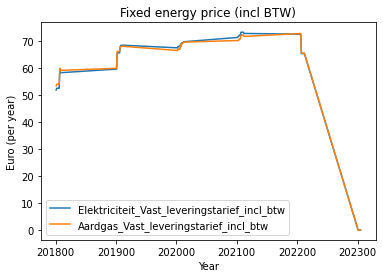

In [22]:
energy_prices[[
    'Elektriciteit_Vast_leveringstarief_incl_btw',
     'Aardgas_Vast_leveringstarief_incl_btw']].plot(kind='line')

plt.title('Fixed energy price (incl BTW)')
plt.xlabel('Year')
plt.ylabel('Euro (per year)')
plt.show()

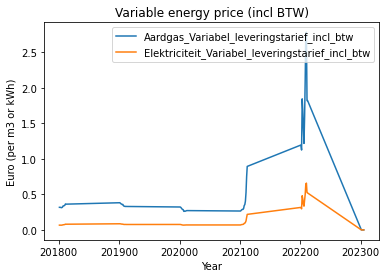

In [23]:
energy_prices[[
    'Aardgas_Variabel_leveringstarief_incl_btw', 
    'Elektriciteit_Variabel_leveringstarief_incl_btw']].plot(kind='line')

plt.title('Variable energy price (incl BTW)')
plt.xlabel('Year')
plt.ylabel('Euro (per m3 or kWh)')
plt.show()

In [24]:
# add year and month columns for later processing
energy_prices.reset_index(inplace=True)

energy_prices['Year'] = energy_prices['MonthYear'].apply(lambda x: int(str(x)[:4]))
energy_prices['Month'] = energy_prices['MonthYear'].apply(lambda x: int(str(x)[4:]))

In [25]:
energy_prices

,MonthYear,Aardgas_Vast_leveringstarief_incl_btw,Aardgas_Vast_leveringstarief_ex_btw,Aardgas_Variabel_leveringstarief_incl_btw,Aardgas_Variabel_leveringstarief_ex_btw,Elektriciteit_Vast_leveringstarief_incl_btw,Elektriciteit_Vast_leveringstarief_ex_btw,Elektriciteit_Variabel_leveringstarief_incl_btw,Elektriciteit_Variabel_leveringstarief_ex_btw,Year,Month
0,201801,53.42,44.15,0.3182,0.2630,51.84,42.84,0.0671,0.0554,2018,1
1,201802,53.98,44.61,0.3180,0.2628,52.49,43.38,0.0670,0.0554,2018,2
2,201803,53.98,44.61,0.3179,0.2627,52.49,43.38,0.0673,0.0556,2018,3
3,201804,53.98,44.61,0.3127,0.2584,52.49,43.38,0.0667,0.0551,2018,4
4,201805,53.98,44.61,0.3145,0.2599,52.49,43.38,0.0676,0.0559,2018,5
...,...,...,...,...,...,...,...,...,...,...,...
60,202301,0.00,0.00,0.0000,0.0000,0.00,0.00,0.0000,0.0000,2023,1
61,202302,0.00,0.00,0.0000,0.0000,0.00,0.00,0.0000,0.0000,2023,2
62,202303,0.00,0.00,0.0000,0.0000,0.00,0.00,0.0000,0.0000,2023,3
63,202304,0.00,0.00,0.0000,0.0000,0.00,0.00,0.0000,0.0000,2023,4


## 5. Renewable energy

In [26]:
ren_energy_path = '../Data/renewable_energy_usage_2015_2022.csv'

ren_energy = pd.read_csv(ren_energy_path, delimiter=';')
ren_energy['Year'] = ren_energy['Jaartal'].str.replace('*', '')
ren_energy.drop(columns=['Jaartal'], inplace=True)
ren_energy.sort_values('Year', inplace=True)
ren_energy.set_index('Year', inplace=True)

for i in ren_energy.columns:
    ren_energy[i] = ren_energy[i].str.replace(',', '.')
    ren_energy[i] = ren_energy[i].astype(float)    

ren_energy

,Biomassa (%),Windenergie (%),Zonne-energie (%),Warmtepompen (%),Overig (%),Statistische overdracht (%)
Year,,,,,,
2015,3.85,1.22,0.25,0.28,0.13,NaN
2016,3.61,1.44,0.33,0.31,0.15,NaN
2017,3.90,1.65,0.43,0.36,0.16,NaN
2018,4.37,1.71,0.69,0.43,0.19,NaN
2019,5.22,1.87,0.99,0.53,0.28,NaN
2020,6.20,2.58,1.68,0.67,0.34,2.53
2021,6.32,3.42,2.12,0.81,0.33,0.00
2022,5.96,4.20,3.34,1.11,0.39,0.00


In [27]:
ren_energy.isna().sum() / len(ren_energy)

Biomassa (%)                   0.000
Windenergie (%)                0.000
Zonne-energie (%)              0.000
Warmtepompen (%)               0.000
Overig (%)                     0.000
Statistische overdracht (%)    0.625
dtype: float64

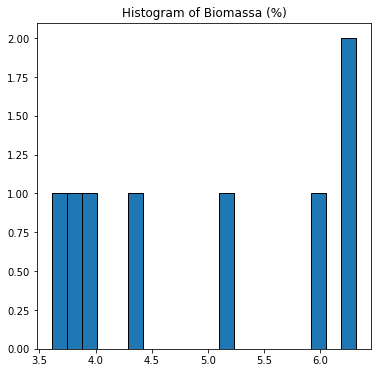

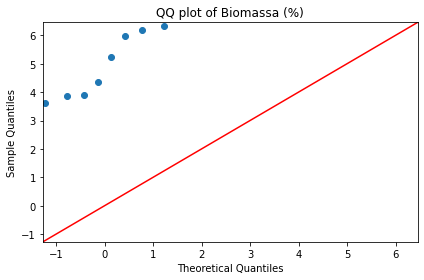

ShapiroResult(statistic=0.8685724139213562, pvalue=0.1459549069404602)


In [28]:
check_normality(df=ren_energy, feature='Biomassa (%)')

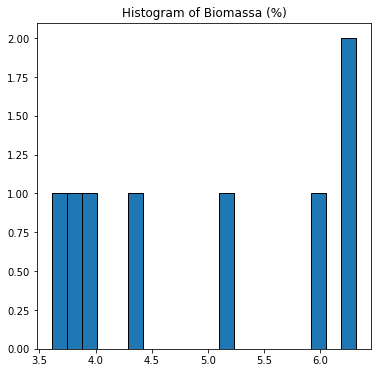

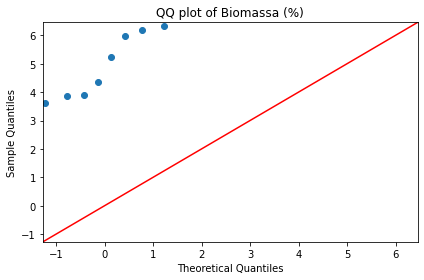

ShapiroResult(statistic=0.8685724139213562, pvalue=0.1459549069404602)


In [29]:
check_normality(df=ren_energy, feature='Biomassa (%)')

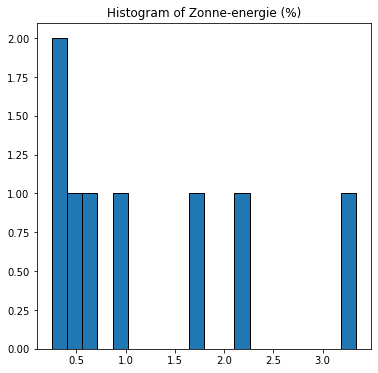

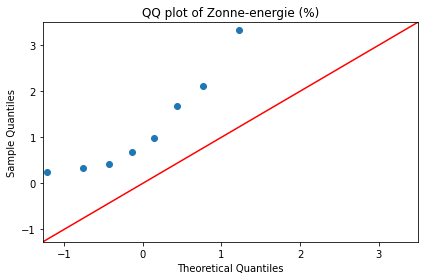

ShapiroResult(statistic=0.8697877526283264, pvalue=0.15001079440116882)


In [30]:
check_normality(df=ren_energy, feature='Zonne-energie (%)')

According to the Shapiro-Wilk test the data does seem to be normal distributed but according to the histogram (and QQ plot) is does not. 

Plot of the different renewable energy types over the years.

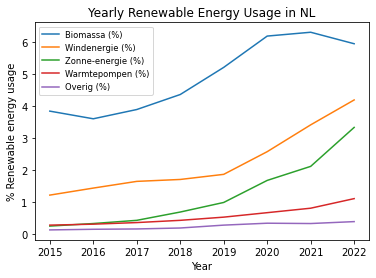

In [31]:
ax = ren_energy[['Biomassa (%)', 
            'Windenergie (%)',
            'Zonne-energie (%)',
            'Warmtepompen (%)',
            'Overig (%)']].plot(kind='line')
plt.xlabel('Year')
plt.ylabel('% Renewable energy usage')
plt.title('Yearly Renewable Energy Usage in NL')
ax.legend(fontsize='small')
plt.show()

In [32]:
ren_energy.reset_index(inplace=True)
ren_energy['Year'] = ren_energy['Year'].astype(int)

## Merge all the datasets together for analysis

In [33]:
# drop some weather and energy price columns for joining
weather_dropped = weather.drop(columns=['Year', 'WeekKey', 'day_of_week', 'Week'])
energy_prices.drop(columns=['MonthYear'], inplace=True)

# merge datasets
df = load_NL.merge(weather_dropped, on=['Date'] , how='left')
df = df.merge(nao, on=['Year', 'Month'], how='left')
df = df.merge(ren_energy, on = 'Year', how='left')
df = df.merge(energy_prices, on = ['Year', 'Month'], how = 'left')

df

,DateUTC,DateShort,LoadConsumption,Date,Hour,Year,Week,WeekKey,day_of_week,DailyPrecipitation,...,Overig (%),Statistische overdracht (%),Aardgas_Vast_leveringstarief_incl_btw,Aardgas_Vast_leveringstarief_ex_btw,Aardgas_Variabel_leveringstarief_incl_btw,Aardgas_Variabel_leveringstarief_ex_btw,Elektriciteit_Vast_leveringstarief_incl_btw,Elektriciteit_Vast_leveringstarief_ex_btw,Elektriciteit_Variabel_leveringstarief_incl_btw,Elektriciteit_Variabel_leveringstarief_ex_btw
0,2021-01-01 00:00:00,01/01/2021,11313.1375,2021-01-01,1,2021,53,202153,Friday,0.0,...,0.33,0.0,70.19,58.01,0.266,0.2198,71.33,58.95,0.0697,0.0576
1,2021-01-01 01:00:00,01/01/2021,10925.1475,2021-01-01,2,2021,53,202153,Friday,0.0,...,0.33,0.0,70.19,58.01,0.266,0.2198,71.33,58.95,0.0697,0.0576
2,2021-01-01 02:00:00,01/01/2021,10576.8200,2021-01-01,3,2021,53,202153,Friday,0.0,...,0.33,0.0,70.19,58.01,0.266,0.2198,71.33,58.95,0.0697,0.0576
3,2021-01-01 03:00:00,01/01/2021,10371.1225,2021-01-01,4,2021,53,202153,Friday,0.0,...,0.33,0.0,70.19,58.01,0.266,0.2198,71.33,58.95,0.0697,0.0576
4,2021-01-01 04:00:00,01/01/2021,10420.2075,2021-01-01,5,2021,53,202153,Friday,0.0,...,0.33,0.0,70.19,58.01,0.266,0.2198,71.33,58.95,0.0697,0.0576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24067,2023-09-30 19:00:00,30/09/2023,12210.0050,2023-09-30,20,2023,39,202339,Saturday,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24068,2023-09-30 20:00:00,30/09/2023,11532.9300,2023-09-30,21,2023,39,202339,Saturday,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24069,2023-09-30 21:00:00,30/09/2023,10355.4475,2023-09-30,22,2023,39,202339,Saturday,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24070,2023-09-30 22:00:00,30/09/2023,9813.3175,2023-09-30,23,2023,39,202339,Saturday,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Flag hours on which precipitation/temperature/windspeed is at its min/max. Drop the corresponding hour columns

In [34]:
hour_cols = [
        'HDMaxPrecipitation',
        'HDMinTemperature',
        'HDMaxTemperature',
        'HDMaxMeanWindspeed',
        'HDMinMeanWindspeed'
    ]

    
for i in hour_cols:
    flag_col_name = i[2:] + 'HourFlag'
    df[flag_col_name] = (df[i] == df['Hour']).astype(int)

df.drop(columns=hour_cols, inplace=True)

In [35]:
df

,DateUTC,DateShort,LoadConsumption,Date,Hour,Year,Week,WeekKey,day_of_week,DailyPrecipitation,...,Aardgas_Variabel_leveringstarief_ex_btw,Elektriciteit_Vast_leveringstarief_incl_btw,Elektriciteit_Vast_leveringstarief_ex_btw,Elektriciteit_Variabel_leveringstarief_incl_btw,Elektriciteit_Variabel_leveringstarief_ex_btw,MaxPrecipitationHourFlag,MinTemperatureHourFlag,MaxTemperatureHourFlag,MaxMeanWindspeedHourFlag,MinMeanWindspeedHourFlag
0,2021-01-01 00:00:00,01/01/2021,11313.1375,2021-01-01,1,2021,53,202153,Friday,0.0,...,0.2198,71.33,58.95,0.0697,0.0576,1,0,0,0,1
1,2021-01-01 01:00:00,01/01/2021,10925.1475,2021-01-01,2,2021,53,202153,Friday,0.0,...,0.2198,71.33,58.95,0.0697,0.0576,0,0,0,0,0
2,2021-01-01 02:00:00,01/01/2021,10576.8200,2021-01-01,3,2021,53,202153,Friday,0.0,...,0.2198,71.33,58.95,0.0697,0.0576,0,1,0,0,0
3,2021-01-01 03:00:00,01/01/2021,10371.1225,2021-01-01,4,2021,53,202153,Friday,0.0,...,0.2198,71.33,58.95,0.0697,0.0576,0,0,0,0,0
4,2021-01-01 04:00:00,01/01/2021,10420.2075,2021-01-01,5,2021,53,202153,Friday,0.0,...,0.2198,71.33,58.95,0.0697,0.0576,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24067,2023-09-30 19:00:00,30/09/2023,12210.0050,2023-09-30,20,2023,39,202339,Saturday,0.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
24068,2023-09-30 20:00:00,30/09/2023,11532.9300,2023-09-30,21,2023,39,202339,Saturday,0.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
24069,2023-09-30 21:00:00,30/09/2023,10355.4475,2023-09-30,22,2023,39,202339,Saturday,0.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
24070,2023-09-30 22:00:00,30/09/2023,9813.3175,2023-09-30,23,2023,39,202339,Saturday,0.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0


**Check for nulls**

In [36]:
df.isna().sum() / len(df) * 100

DateUTC                                             0.000000
DateShort                                           0.000000
LoadConsumption                                     0.000000
Date                                                0.000000
Hour                                                0.000000
Year                                                0.000000
Week                                                0.000000
WeekKey                                             0.000000
day_of_week                                         0.000000
DailyPrecipitation                                  0.000000
MaxHourlyPrecipitation                              0.000000
DailyMeanTemperature                                0.000000
HourlyMinTemperature                                0.000000
HourlyMaxTemperature                                0.000000
DailyMeanWindspeed                                  0.000000
MaxHourlyMeanWindspeed                              0.000000
MinHourlyMeanWindspeed  

There are some nulls. This is caused by the joining of the datasets. Check for the min and max dates of all the individual datasets

In [37]:
print('weather', weather['Date'].min(), weather['Date'].max())
print('nao', nao['Year'].min(), nao['Year'].max())
print('renewable energy', ren_energy['Year'].min(), ren_energy['Year'].max())
print('prices', energy_prices['Year'].min(), energy_prices['Year'].max())

weather 2021-01-01 00:00:00 2024-01-10 00:00:00
nao 1950 2023
renewable energy 2015 2022
prices 2018 2023


In [38]:
energy_prices[energy_prices['Year'] == 2023]['Month'].max()

5

Energy prices has max year 2023 and month 5, so it goes until May 2023. Renewable energy only goes until 2022. This gives us the following options:
* Filter joined dataset until 2022 -> this does give us a year less of data
* Don't use renewable energy and energy price -> this gives us more data but less features
* Fill in the nulls -> this gives us all the data but might not be very accurate. Also we need to think of a way to impute the nulls. Use trend of the data? Average?


We choose to fill the nulls in the dataset. We will do this outside of the EDA.

### Analysis 1: Per day we can see on which hour the minimum/maximum precipitation, windspeed and temperature occurred. We want to know how often a certain hour has this min/max. 

We want to know this because we can maybe check per week/month what the highest temperature/windspeed/precipitation hour is on average. 
* E.g. we can use this to flag a certain hour in the load dataset: Highest...HourFlag, Lowest...HourFlag. This might be useful as for instance the higehst temperature hour might indicate that less/more energy is needed depending on the season: in the winter then less heating is required, while in the summer then more cooling is required.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


HDMaxPrecipitation
1     586
2      21
3      23
4      18
5      22
6      20
7      31
8      14
9      19
10     20
11     20
12     21
13     25
14     31
15     29
16     27
17     19
18     16
19     23
20     19
21     16
22     22
23     32
24     31
Name: Date, dtype: int64


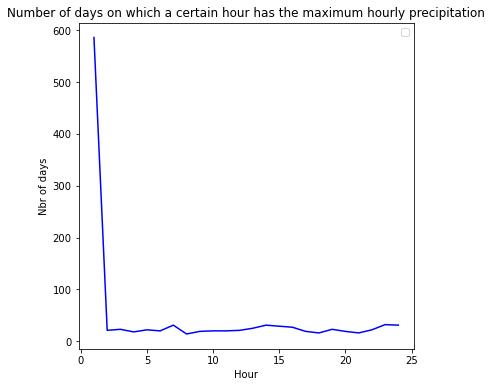

In [39]:
# group weather df by hourly preciptitation
grouped_hourly_preciptitation = weather.groupby('HDMaxPrecipitation')['Date'].count()
print(grouped_hourly_preciptitation)

# plot
plt.figure(figsize=(6, 6))

plt.plot(
    grouped_hourly_preciptitation.index, 
    grouped_hourly_preciptitation.values, 
    color='blue'
)
plt.title('Number of days on which a certain hour has the maximum hourly precipitation')
plt.xlabel('Hour')
plt.ylabel('Nbr of days')
plt.legend()

The above grouped df and plot show on how often a certain our of day has the maximimum hourly precipitation. Clearly visible in both is that hour 1 of the day often has the maximum hourly precipitation. 

In [40]:
len(weather[weather['HDMaxPrecipitation'] == 1]) / len(weather) * 100

53.0316742081448

This is the case for 53% of the days in the dataset.

Next, we check on which hours of day the minimum hourly temperatures occur the most

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


HDMinTemperature
1     120
2      63
3      90
4     165
5     108
6      63
7      48
8      25
9       5
10      6
11      1
12      3
13      1
14      2
15      3
16      2
17      6
18     10
19     15
20     15
21     19
22     30
23     48
24    257
Name: Date, dtype: int64


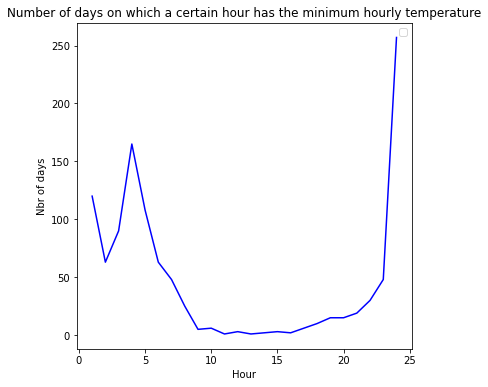

In [41]:
# group weather df by hourly min temperature
grouped_hourly_min_temperature = weather.groupby('HDMinTemperature')['Date'].count()
print(grouped_hourly_min_temperature)

# plot
plt.figure(figsize=(6, 6))

plt.plot(
    grouped_hourly_min_temperature.index, 
    grouped_hourly_min_temperature.values, 
    color='blue'
)
plt.title('Number of days on which a certain hour has the minimum hourly temperature')
plt.xlabel('Hour')
plt.ylabel('Nbr of days')
plt.legend()

In [42]:
len(weather[weather['HDMinTemperature'] == 24]) / len(weather) * 100

23.257918552036198

We can see that in 23.3% of the days, hour 24 has the minimum temperature. In the plot, we can see a logical pattern: we can see that during the evening/night hours the temperature is at its minimum.

Next, we check on which hours of day the maximum hourly temperatures occur the most

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


HDMaxTemperature
1      42
2       9
3       5
4       3
5       6
6       3
7       1
8       1
9       4
10     21
11     40
12     96
13    184
14    268
15    229
16    101
17     26
18      7
19     10
20      6
21     10
22      7
23      8
24     18
Name: Date, dtype: int64


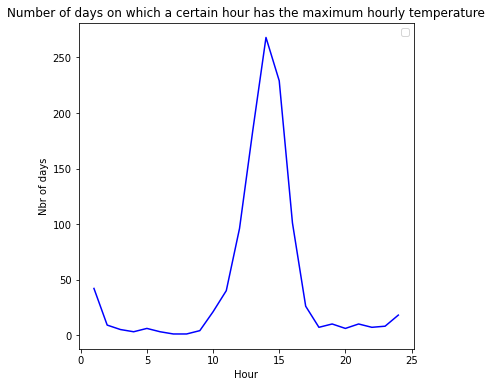

In [43]:
# group weather df by hourly max temperature
grouped_hourly_max_temperature = weather.groupby('HDMaxTemperature')['Date'].count()
print(grouped_hourly_max_temperature)

# plot
plt.figure(figsize=(6, 6))

plt.plot(
    grouped_hourly_max_temperature.index, 
    grouped_hourly_max_temperature.values, 
    color='blue'
)
plt.title('Number of days on which a certain hour has the maximum hourly temperature')
plt.xlabel('Hour')
plt.ylabel('Nbr of days')
plt.legend()

In [44]:
len(weather[weather['HDMaxTemperature'] == 14]) / len(weather) * 100

24.25339366515837

Hour 14 occurs the most frequent as highest temperature hour with 24.3% of the time. Again, in the plot we see a logical pattern. The maximum hourly temperature occurs most often during the afternoon. This makes sense because it is always the warmest during the afternoon because then the sun is at its highest. 

In [45]:
# group by week key to get max temperature of the week
max_temp_by_week = weather.groupby('WeekKey')['DailyMeanTemperature'].max()

# join this back to the weather df and rename columns
weather_joined = weather.merge(max_temp_by_week, left_on='WeekKey', right_index=True)
weather_joined.rename(
    columns=
    {
        'DailyMeanTemperature_x':'DailyMeanTemperature',
        'DailyMeanTemperature_y':'MaxTemperatureOfWeek'
    }, 
    inplace=True
)

# check which day had the max temperature
weather_joined['DayWithMaxTemp'] = weather_joined['DailyMeanTemperature'] == weather_joined['MaxTemperatureOfWeek']

# check how often a certain day has the max temperature
weather_joined[weather_joined['DayWithMaxTemp'] == True]['day_of_week'].value_counts()

Sunday       33
Monday       30
Tuesday      22
Wednesday    21
Saturday     20
Friday       20
Thursday     17
Name: day_of_week, dtype: int64

Above, we can see that sunday often has the highest temperature. We could possibly use this as a flag.

Next, we check this frequency for the winter periods only.

In [46]:
# group by week key to get max temperature of the week
weather_in_winter = weather[weather['Date'].dt.month.isin([12, 1, 2])]

max_temp_by_week = weather_in_winter.groupby('WeekKey')['DailyMeanTemperature'].max()

# join this back to the weather df and rename columns
winter_joined = weather_in_winter.merge(max_temp_by_week, left_on='WeekKey', right_index=True)
winter_joined.rename(
    columns=
    {
        'DailyMeanTemperature_x':'DailyMeanTemperature',
        'DailyMeanTemperature_y':'MaxTemperatureOfWeek'
    }, 
    inplace=True
)

# check which day had the max temperature
winter_joined['DayWithMaxTemp'] = winter_joined['DailyMeanTemperature'] == winter_joined['MaxTemperatureOfWeek']

# check how often a certain day has the max temperature
winter_joined[winter_joined['DayWithMaxTemp'] == True]['day_of_week'].value_counts()

Wednesday    9
Sunday       8
Tuesday      7
Monday       7
Saturday     6
Friday       5
Thursday     3
Name: day_of_week, dtype: int64

Here we can see that in the winter months, wednesday often has the highest temperature. 

### Analysis 2:  Plot the load consumption per year/winter/week/day to see if we see a recurring pattern.

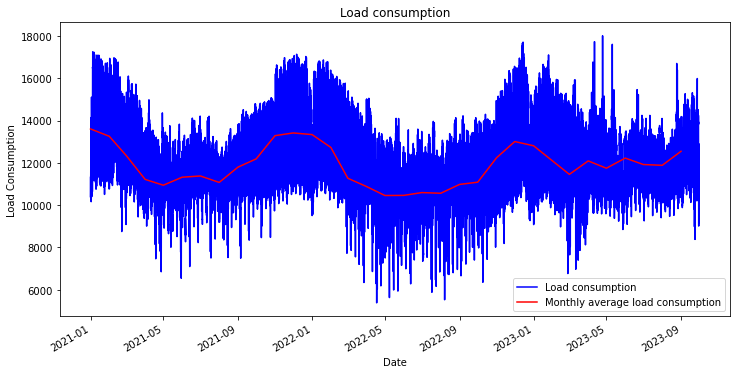

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(
    load_NL['DateUTC'], 
    load_NL['LoadConsumption'], 
    label='Load consumption', 
    color='blue'
)

monthly_load = load_NL.groupby(load_NL['DateUTC'].dt.to_period('M'))['LoadConsumption'].mean()

monthly_load.plot(kind='line', color='red', label='Monthly average load consumption')

plt.title('Load consumption')
plt.xlabel('Date')
plt.ylabel('Load Consumption')
plt.legend()
plt.show()

Above we can see that the load consumption has seasonality. It goes up in the winters and down during the summers. 

**Plot of two winters**

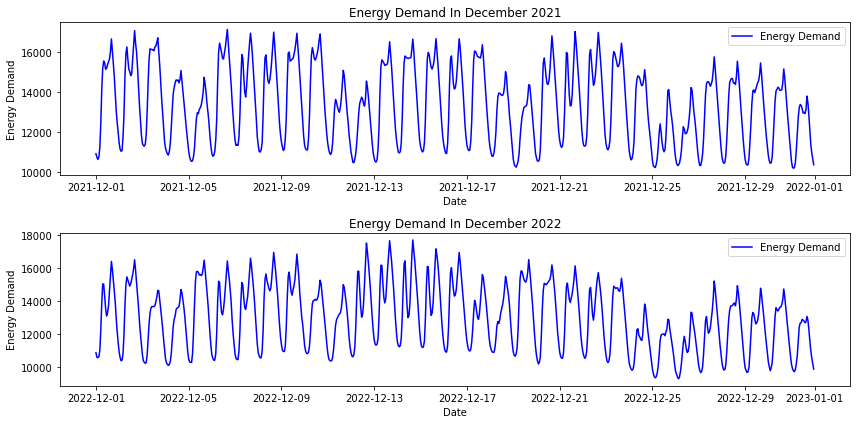

In [48]:
df_winter_2021_2022 = load_NL[(load_NL['Date'] >= '2021-12-01') & (load_NL['Date'] < '2022-01-01')]
df_winter_2022_2023 = load_NL[(load_NL['Date'] >= '2022-12-01') & (load_NL['Date'] < '2023-01-01')]

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(
    df_winter_2021_2022['DateUTC'], 
    df_winter_2021_2022['LoadConsumption'], 
    label='Energy Demand', 
    color='blue')
plt.title('Energy Demand In December 2021')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(
    df_winter_2022_2023['DateUTC'], 
    df_winter_2022_2023['LoadConsumption'],
    label='Energy Demand',
    color='blue')
plt.title('Energy Demand In December 2022')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.legend()

plt.tight_layout()

plt.show()

We can see a similar pattern in both years. What we see is a peak on each day as there are 31 peaks in the month (and December has 31 days), indicating that there is daily seasonality in this data. 

Moreover, we can see that there is a repetitive pattern of every time 5 high peaks and then 2 low(er) peaks. The 5 high peaks are for the week days and the 2 low peaks are for the weekend days. This effect is especially clear in the first subplot of December 2021.

A possible explanation for this is that people are more at home during the weekdays (e.g. for working from home which is especially the case ever since Covid-19 started) which simply requires more energy. In the weekend days, people are away from home and this costs less energy. 

**Plot of a single week**

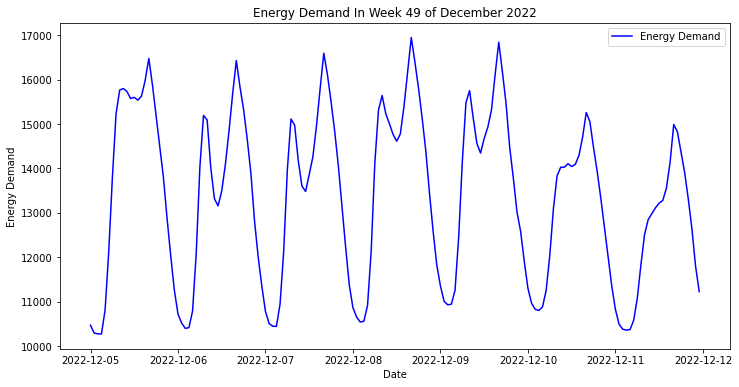

In [49]:
df_1_week = load_NL[(load_NL['Date'] >= '2022-12-05') & (load_NL['Date'] <= '2022-12-11')]

plt.figure(figsize=(12, 6))
plt.plot(df_1_week['DateUTC'], df_1_week['LoadConsumption'], label='Energy Demand', color='blue')
plt.title('Energy Demand In Week 49 of December 2022')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.legend()

plt.show()

In the week plot, we can see a similar pattern as in the month plot. During the weekdays, the load consumption is higher than the weekend days. Each day has a similar pattern though (hour-to-hour).

**Finally, a plot of the load consumption of a single day**

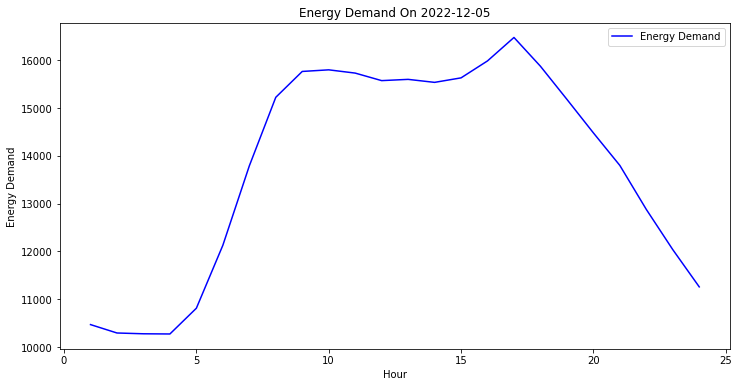

In [50]:
df_1_day = load_NL[(load_NL['Date'] == '2022-12-05')]

plt.figure(figsize=(12, 6))
plt.plot(df_1_day['Hour'], df_1_day['LoadConsumption'], label='Energy Demand', color='blue')
plt.title('Energy Demand On 2022-12-05')
plt.xlabel('Hour')
plt.ylabel('Energy Demand')
plt.legend()

plt.show()

Here we can see the pattern that occurs daily. Load consumption is the highest during the day hours and lowest during the night. 

**Next, we plot the yearly consumption to see what trend there is throughout the years.**

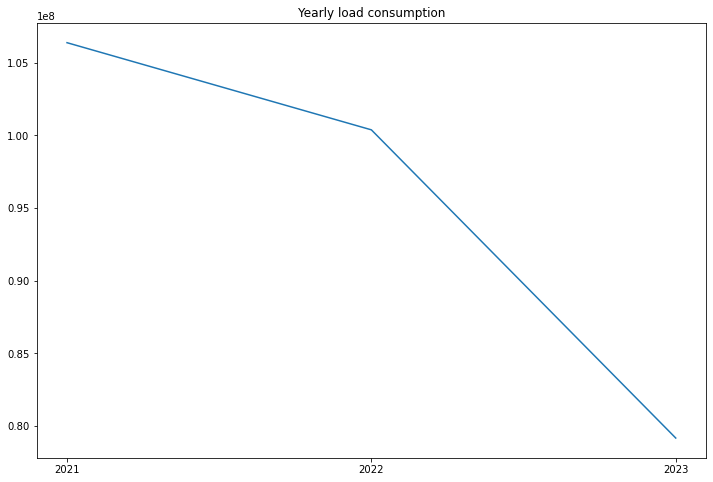

In [51]:
yearly_consumption = load_NL.groupby(load_NL['Date'].dt.year)['LoadConsumption'].sum()
plt.figure(figsize=(12, 8))
plt.title('Yearly load consumption')
x = [2021, 2022, 2023]
default_x_ticks = range(len(x))
plt.xticks(default_x_ticks, x)
plt.plot(default_x_ticks, yearly_consumption.values, label='Original')


We can see that the load consumption goes down with the years. Where the decrease from 2022-2023 is bigger than the decrease from 2021-2022.

**Check in the weather data to see if this downward trend makes sense, e.g. higher temperature could explain this.** 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


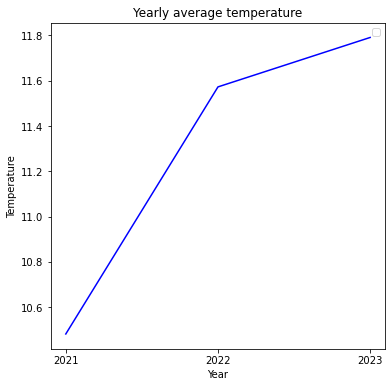

In [52]:
yearly_temperature = weather[weather['Year'] < 2024].groupby('Year')['DailyMeanTemperature'].mean()

plt.figure(figsize=(6, 6))
x = [2021, 2022, 2023]
default_x_ticks = range(len(x))
plt.xticks(default_x_ticks, x)
plt.plot(
    default_x_ticks, 
    yearly_temperature.values, 
    color='blue'
)

plt.title('Yearly average temperature')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend()

Indeed, we can see that the temperature has a upward trend. This could explain why the demand for energy goes down.

Next, we check how often a certain day has the maximum load.

In [53]:
max_load_by_week = load_NL.groupby('WeekKey')['LoadConsumption'].max()

# join this back to the weather df and rename columns
load_joined = load_NL.merge(max_load_by_week, left_on='WeekKey', right_index=True)
load_joined.rename(
    columns=
    {
        'LoadConsumption_x':'LoadConsumption',
        'LoadConsumption_y':'MaxLoadConsumption'
    }, 
    inplace=True
)

# check which day had the max load
load_joined['DayWithMaxLoad'] = load_joined['LoadConsumption'] == load_joined['MaxLoadConsumption']


# check how often a certain day has the max load
load_joined[load_joined['DayWithMaxLoad'] == True]['day_of_week'].value_counts()

Thursday     45
Monday       37
Tuesday      27
Wednesday    24
Friday        9
Saturday      2
Sunday        1
Name: day_of_week, dtype: int64

Looking at all months, we can see that thursdays have the highest load the most frequently.

In [54]:
# group by week key to get max load of the week
load_in_winter = load_NL[load_NL['Date'].dt.month.isin([12, 1, 2])]

max_load_by_week = load_in_winter.groupby('WeekKey')['LoadConsumption'].max()

# join this back to the weather df and rename columns
load_joined = load_NL.merge(max_load_by_week, left_on='WeekKey', right_index=True)
load_joined.rename(
    columns=
    {
        'LoadConsumption_x':'LoadConsumption',
        'LoadConsumption_y':'MaxLoadConsumption'
    }, 
    inplace=True
)

# check which day had the max load
load_joined['DayWithMaxLoad'] = load_joined['LoadConsumption'] == load_joined['MaxLoadConsumption']


# check how often a certain day has the max load
load_joined[load_joined['DayWithMaxLoad'] == True]['day_of_week'].value_counts()

Monday       14
Wednesday     8
Tuesday       7
Thursday      6
Saturday      1
Friday        1
Sunday        1
Name: day_of_week, dtype: int64

Looking at just the winter period, Monday has the highest load consumption the most frequently. Followed by the other week days. Friday, Saturday and Sunday have the lowest. 

### Analysis 3: Decomposition of load consumption data

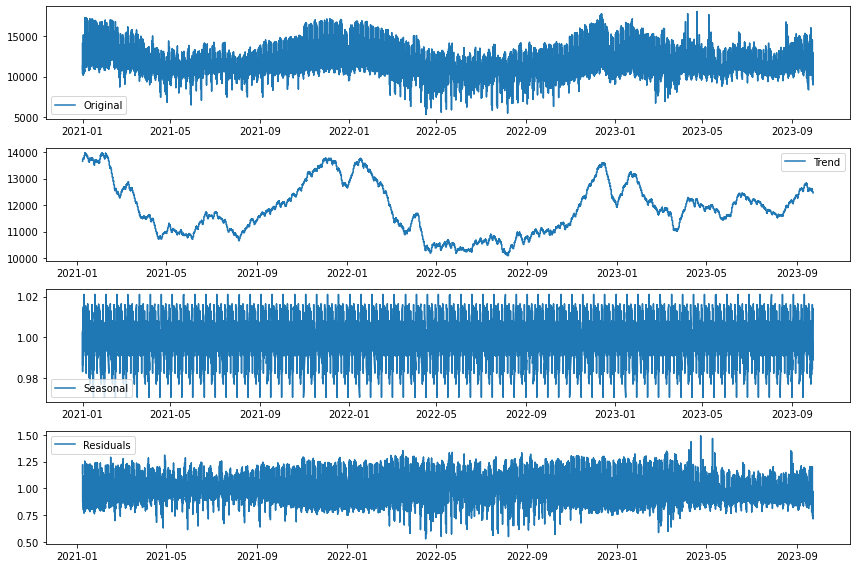

In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_decomp = load_NL.set_index('Date')

result = seasonal_decompose(df_decomp['LoadConsumption'], model='multiplicative', period=365)  

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(df_decomp.index, df_decomp['LoadConsumption'], label='Original')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

We can see that the trend of the data goes up and down. This follows the same pattern approximately every year. The trend goes up as the winter comes and goes down after. In the seasonal plot we can see a lot of movement. This is because the data has lots of seasonality. Each day has the same pattern.

### Analysis 4:

Join load consumption data with the other data sources and look at the interaction of variables

**Analysis 4.1: Scaled plot of monthly load, precipitation and temperature**

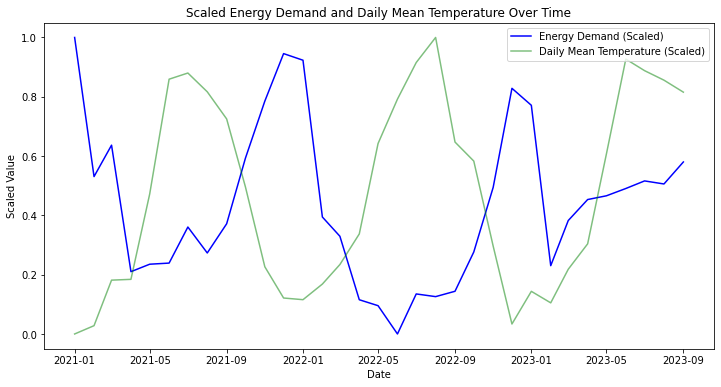

In [56]:
# group on month level
monthly = df.groupby(
    df['Date'].dt.to_period("M")).agg(
    {
        'LoadConsumption': 'sum', 
         'DailyPrecipitation': 'sum',
         'DailyMeanTemperature': 'sum',
    }
).reset_index()

# normalize the data using minmaxscaler
scaler = MinMaxScaler()
monthly[['daily_load_scaled', 'DailyPrecipitation_scaled', 'DailyMeanTemperature_scaled']] = scaler.fit_transform(
    monthly[['LoadConsumption', 'DailyPrecipitation', 'DailyMeanTemperature']]
)

# plot
plt.figure(figsize=(12, 6))
plt.plot(
    monthly['Date'].dt.to_timestamp(), 
    monthly['daily_load_scaled'], 
    label='Energy Demand (Scaled)', 
    color='blue',
    alpha=1
)

plt.plot(
    monthly['Date'].dt.to_timestamp(), 
    monthly['DailyMeanTemperature_scaled'], 
    label='Daily Mean Temperature (Scaled)', 
    color='green',
    alpha=0.5
)

plt.title('Scaled Energy Demand and Daily Mean Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.legend(loc='upper right')

plt.show()

In the plot above, we can see a pattern where every time the enrgy demand goes up, the temperature goes down and vice versa.

 **Analysis 4.2: scaled plot of daily load/temperature for winter 2021-2022**

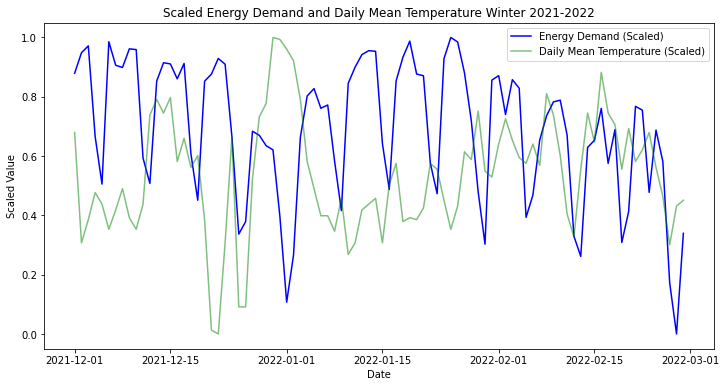

In [57]:
# normalize the data using minmaxscaler
scaler = MinMaxScaler()
df_daily = df.groupby('Date').agg(  {
         'LoadConsumption': 'sum', 
         'DailyPrecipitation': 'mean',
         'DailyMeanTemperature': 'mean',
    }
).reset_index()
df_winter_2021_2022 = df_daily[(df_daily['Date'] >= '2021-12-01') & (df_daily['Date'] < '2022-03-01')]
df_winter_2021_2022[
    ['LoadConsumption_scaled', 'DailyPrecipitation_scaled', 'DailyMeanTemperature_scaled']
] = scaler.fit_transform(
    df_winter_2021_2022[['LoadConsumption', 'DailyPrecipitation', 'DailyMeanTemperature']]
)

# plot
plt.figure(figsize=(12, 6))
plt.plot(
    df_winter_2021_2022['Date'], 
    df_winter_2021_2022['LoadConsumption_scaled'], 
    label='Energy Demand (Scaled)', 
    color='blue',
    alpha=1
)

plt.plot(
    df_winter_2021_2022['Date'], 
    df_winter_2021_2022['DailyMeanTemperature_scaled'], 
    label='Daily Mean Temperature (Scaled)', 
    color='green',
    alpha=0.5
)

plt.title('Scaled Energy Demand and Daily Mean Temperature Winter 2021-2022')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.legend(loc='upper right')

plt.show()

Above, we zoom into just one winter (December 2021-February 2022). We see a similar pattern as in the previous plot. If the temperature goes down, the energy demand goes up. This makes sense because people need to heat up the house when the temperatures drop and also might spend more time inside.

## Analysis 4.3: Multiple Linear Regression fit to the daily features and NAO index

Root Mean Squared Error on Test Data: 2299.6715210074804
Correlation: -0.05773285303594856 and p-value: 6.113215074153206e-05 on Test Data


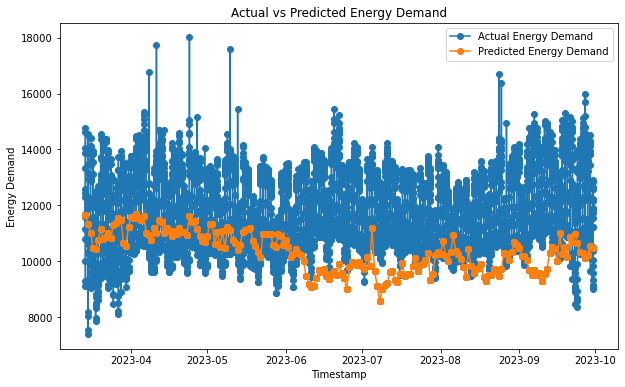

In [357]:
train_size = int(0.8 * len(df))
train_data, test_data = df[:train_size], df[train_size:]

features = [
            'DailyPrecipitation',
        'DailyMeanTemperature',
        'DailyMeanWindspeed',
#         'HourlyMaxTemperature',
#         'MaxHourlyPrecipitation',  
#         'MaxHourlyMeanWindspeed', 
        'NAO',
        'Month', 
        'Year',
]
target = 'LoadConsumption'

# Extract features and target variable from the training and testing sets
X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
rmse = sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error on Test Data: {rmse}')

corr, p_value = pearsonr(y_test, predictions)
print(f'Correlation: {corr} and p-value: {p_value} on Test Data')
    
# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_data['Date'], y_test, label='Actual Energy Demand', marker='o')
plt.plot(test_data['Date'], predictions, label='Predicted Energy Demand', marker='o')
plt.xlabel('Timestamp')
plt.ylabel('Energy Demand')
plt.title('Actual vs Predicted Energy Demand')
plt.legend()
plt.show()


In the plot, in blue we can see the actual energy demand. This is on hourly level. We can see that there is a big distance between the actual energy demand and the predicted. Since we are only using daily features here, it does not make sense to use the hourly energy demand because all the predictors are the same for the entire day. Rather, we aggregate to a daily level and then predict. This should reduce the RMSE as well. 

### **Analysis 4.5: Prophet**

In [60]:
def initialize_prophet(regressors, add_seasonality, fourier_weekly, fourier_annual):
    """
    Initialize prophet. Either with specified seasonalities or default. 
    Add regressors if any are entered. 
    """
    if add_seasonality:
        model = Prophet(
            daily_seasonality=False,
            weekly_seasonality=fourier_weekly,
            yearly_seasonality=fourier_annual,
        )

    else:
        model = Prophet()
        
    if len(regressors) > 0:
        for regressor in regressors:
            model.add_regressor(regressor)
    
    return model

def run_model(train, test, regressors, add_seasonality, fourier_weekly, fourier_annual):
    """
    Run model.
    Give predictions.
    Calculate RMSE.
    """

    # intialize model
    model = initialize_prophet(regressors, add_seasonality, fourier_weekly, fourier_annual)

    # fit model
    model.fit(train)

    # predict with model 
    forecast = model.predict(test)
    forecast['yhat_rounded'] = forecast['yhat'].apply(lambda x: math.floor(x))

    # calculate rmse
    rmse = sqrt(mean_squared_error(test['y'], forecast['yhat_rounded'][-len(test):]))
    
    corr, p_value = pearsonr(y_test, predictions)
    print(f'Correlation: {corr} and p-value: {p_value} on Test Data')
    return rmse

In [61]:
df_prophet = df.rename(columns={"DateUTC": "ds", "LoadConsumption": "y"})
train_size = int(0.8 * len(df_prophet))
train_data, test_data = df_prophet[:train_size], df_prophet[train_size:]

**no regressors, no seasonality**

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


RMSE: 1415.552118099174
Correlation: 0.7285420461682013 and p-value: 0.0 on Test Data


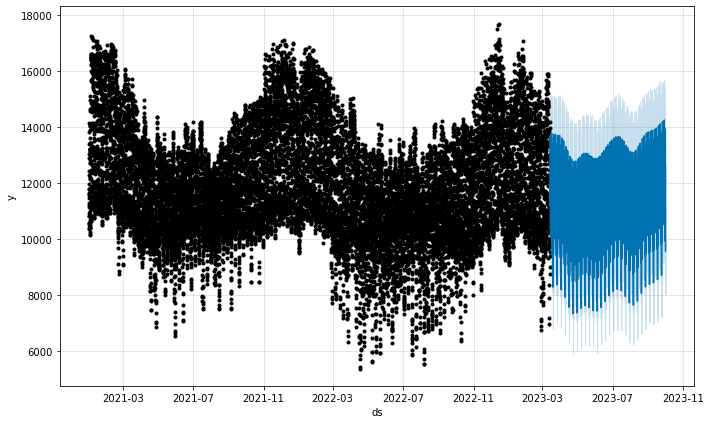

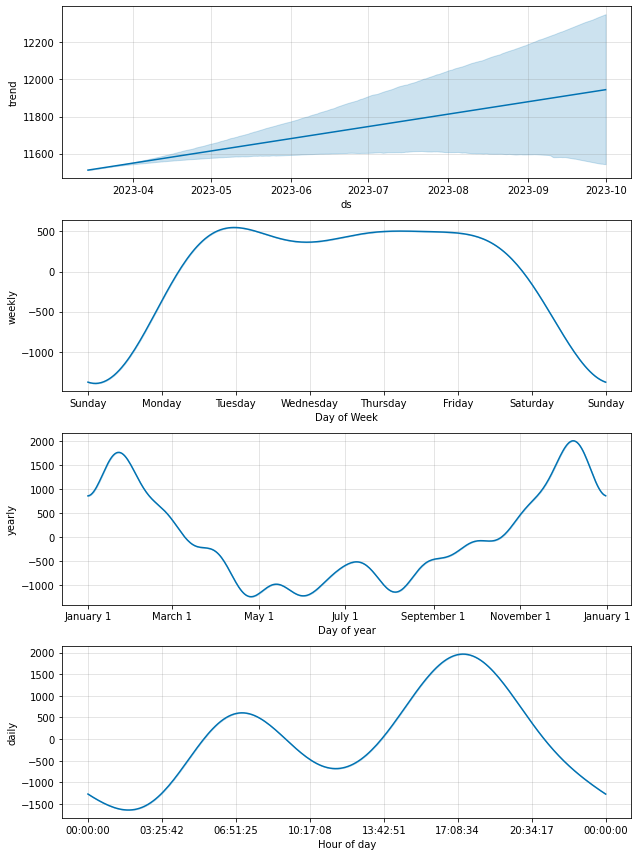

In [62]:
# intialize model
model = initialize_prophet(regressors=[], add_seasonality=False, fourier_weekly=0, fourier_annual=0)

# fit model
model.fit(train_data)

# predict with model 
forecast = model.predict(test_data)
forecast['yhat_rounded'] = forecast['yhat'].apply(lambda x: math.floor(x))

# calculate rmse
print("RMSE:", sqrt(mean_squared_error(test_data['y'], forecast['yhat_rounded'][-len(test_data):])))
corr, p_value = pearsonr(test_data['y'], forecast['yhat_rounded'][-len(test_data):])
print(f'Correlation: {corr} and p-value: {p_value} on Test Data')

# plot
fig1 = model.plot(forecast)

fig2 = model.plot_components(forecast)

**with regressors and fourier terms**

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


RMSE: 1355.7261972154338
Correlation: 0.6611963439202649 and p-value: 0.0 on Test Data


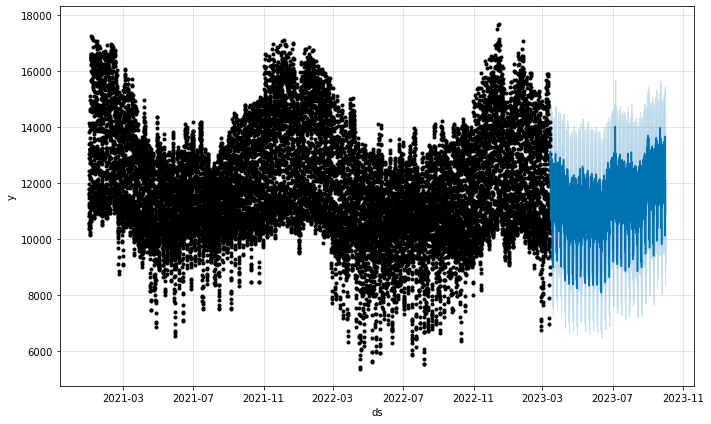

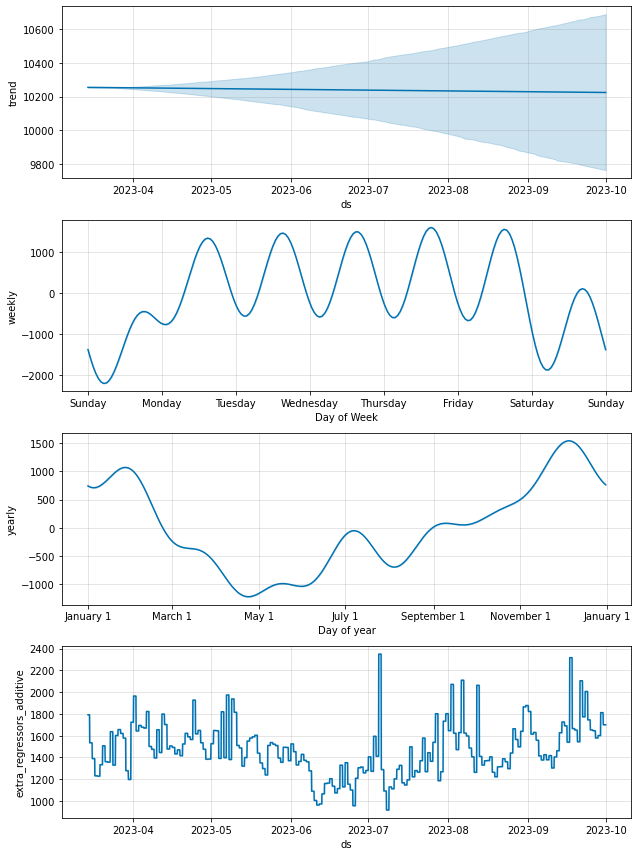

In [63]:
# intialize model
model = initialize_prophet(
    regressors=[
        'DailyPrecipitation',
        'DailyMeanTemperature',
        'DailyMeanWindspeed',
        'NAO',
        'Month', 
        'Year',
    ],
    add_seasonality=True, 
    fourier_weekly=7, 
    fourier_annual=7
)

# fit model
model.fit(train_data)

# predict with model 
forecast = model.predict(test_data)
forecast['yhat_rounded'] = forecast['yhat'].apply(lambda x: math.floor(x))

# calculate rmse
print("RMSE:", sqrt(mean_squared_error(test_data['y'], forecast['yhat_rounded'][-len(test_data):])))
corr, p_value = pearsonr(test_data['y'], forecast['yhat_rounded'][-len(test_data):])
print(f'Correlation: {corr} and p-value: {p_value} on Test Data')

# plot
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

**Letting prophet pick the seasonalities itself, just saying that daily, weekly and yearly seasonality is True**

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


RMSE: 1197.4274363267007
Correlation: 0.7344082153606007 and p-value: 0.0 on Test Data


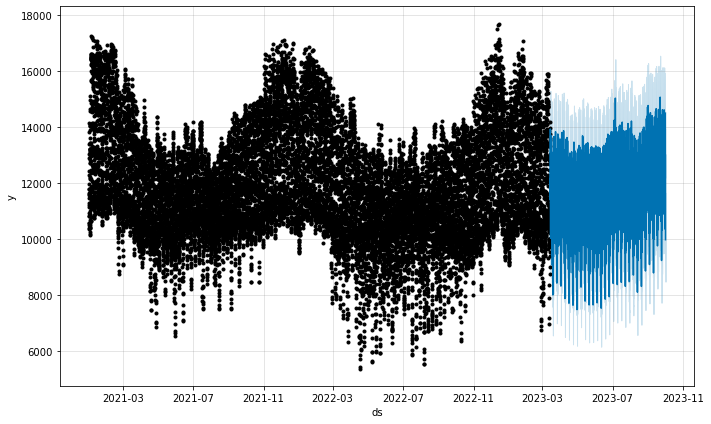

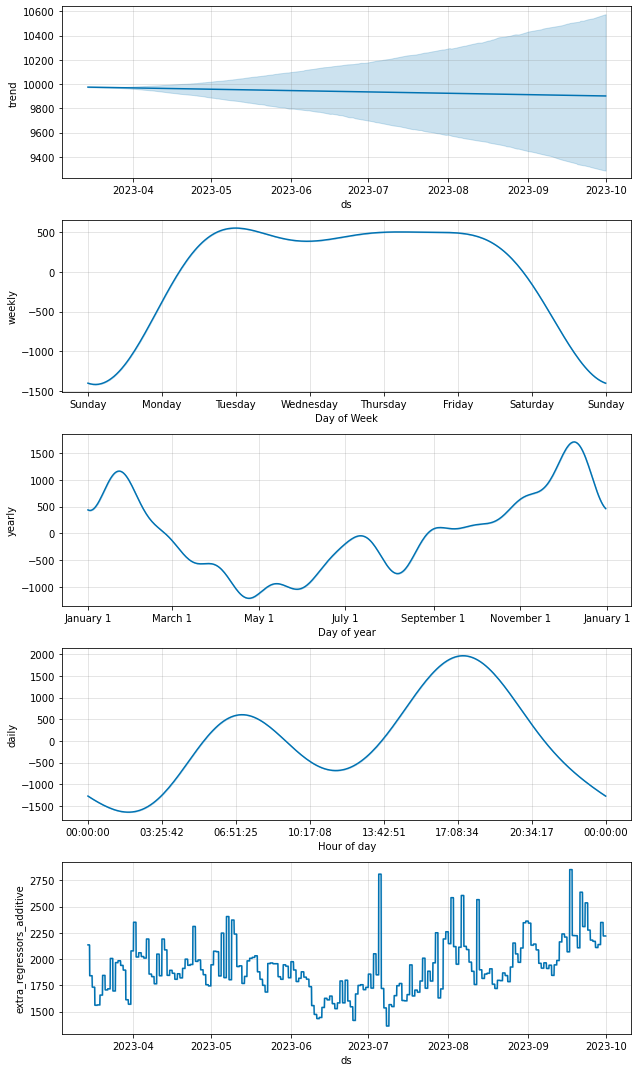

In [64]:
# intialize model
regressors=[
        'DailyPrecipitation',
        'DailyMeanTemperature',
        'DailyMeanWindspeed',
        'NAO',
        'Month', 
        'Year',
]

model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
)


if len(regressors) > 0:
    for regressor in regressors:
        model.add_regressor(regressor)

# fit model
model.fit(train_data)

# predict with model 
forecast = model.predict(test_data)
forecast['yhat_rounded'] = forecast['yhat'].apply(lambda x: math.floor(x))

# calculate rmse
print("RMSE:", sqrt(mean_squared_error(test_data['y'], forecast['yhat_rounded'][-len(test_data):])))
corr, p_value = pearsonr(test_data['y'], forecast['yhat_rounded'][-len(test_data):])
print(f'Correlation: {corr} and p-value: {p_value} on Test Data')

# plot
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

## Analysis 4.6: Pearson correlation test between all the predictors and load

In [65]:
import seaborn as sns

def corr_matrix(df):
    correlation_matrix = df.corr()
    fig, ax = plt.subplots(figsize=(15,15))    

    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix')
    plt.show()

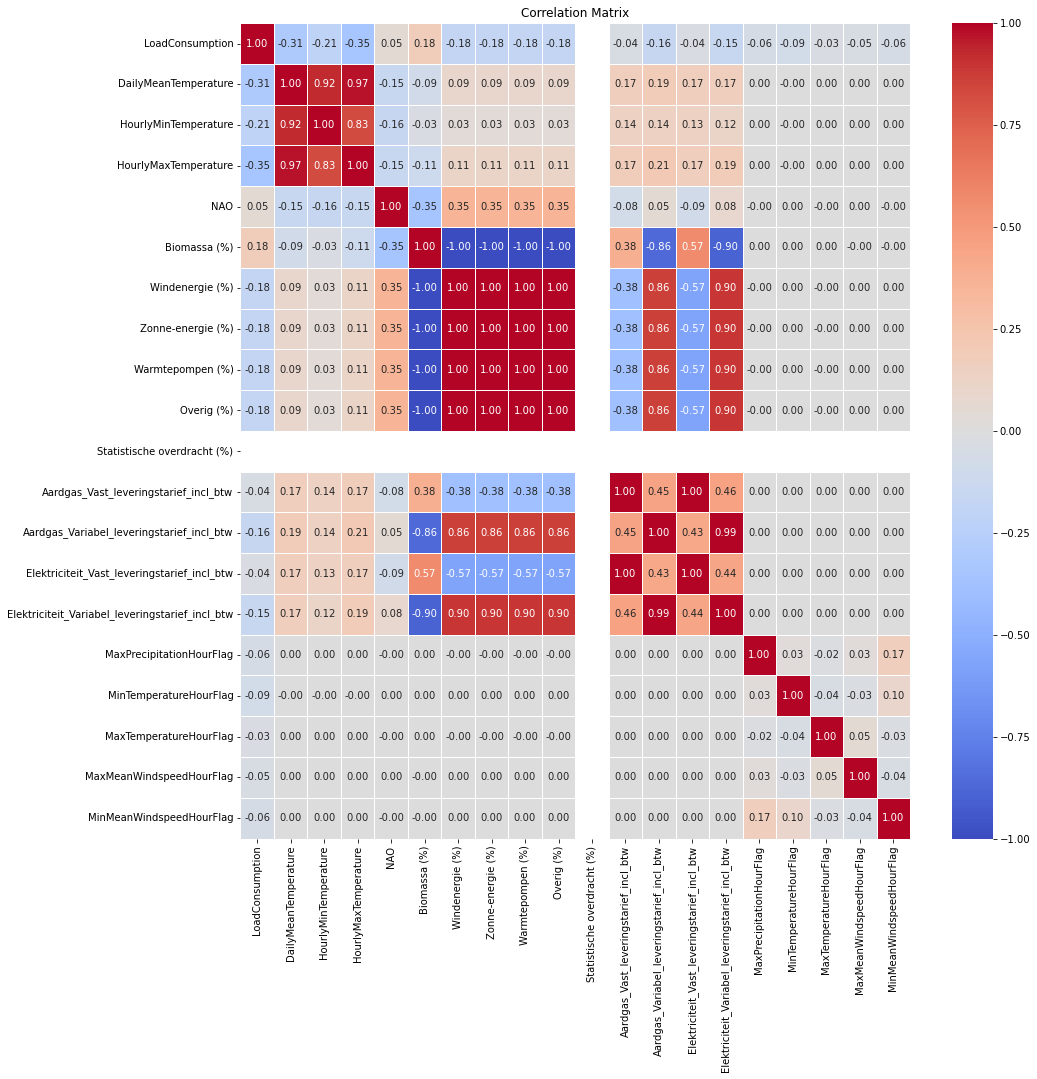

In [67]:
corr_matrix(df[['LoadConsumption', 'DailyPrecipitation',
       'MaxHourlyPrecipitation', 'DailyMeanTemperature',
       'HourlyMinTemperature', 'HourlyMaxTemperature', 'DailyMeanWindspeed',
       'MaxHourlyMeanWindspeed', 'MinHourlyMeanWindspeed', 'NAO',
       'Biomassa (%)', 'Windenergie (%)', 'Zonne-energie (%)',
       'Warmtepompen (%)', 'Overig (%)', 'Statistische overdracht (%)',
       'Aardgas_Vast_leveringstarief_incl_btw',
       'Aardgas_Variabel_leveringstarief_incl_btw',
       'Elektriciteit_Vast_leveringstarief_incl_btw',
       'Elektriciteit_Variabel_leveringstarief_incl_btw',
       'MaxPrecipitationHourFlag', 'MinTemperatureHourFlag',
       'MaxTemperatureHourFlag', 'MaxMeanWindspeedHourFlag',
       'MinMeanWindspeedHourFlag']])

For the pearson r test, we split the test into two parts as the test can't handle nulls in the data. For the first part, we test on all the years since these features don't contain nulls.

In [68]:
from scipy.stats import pearsonr

possible_predictors = [
    'DailyPrecipitation',
       'MaxHourlyPrecipitation', 'DailyMeanTemperature',
       'HourlyMinTemperature', 'HourlyMaxTemperature', 'DailyMeanWindspeed',
       'MaxHourlyMeanWindspeed', 'MinHourlyMeanWindspeed', 'NAO',
       'MaxPrecipitationHourFlag', 'MinTemperatureHourFlag',
       'MaxTemperatureHourFlag', 'MaxMeanWindspeedHourFlag',
       'MinMeanWindspeedHourFlag'
]

target_var = 'LoadConsumption'
alpha = 0.05

for predictor in possible_predictors:
    print(f'--------------------{predictor}--------------------')
    corr, p_value = pearsonr(df[target_var], df[predictor])
    print(f"Correlation: {corr:.2f}, p-value: {p_value}")
    if p_value < alpha:
        print("SIGNIFICANT")
    else:
        print("NOT SIGNIFICANT")
    print('')

--------------------DailyPrecipitation--------------------
Correlation: 0.09, p-value: 3.721329976276096e-40
SIGNIFICANT

--------------------MaxHourlyPrecipitation--------------------
Correlation: 0.03, p-value: 2.746445773881304e-07
SIGNIFICANT

--------------------DailyMeanTemperature--------------------
Correlation: -0.31, p-value: 0.0
SIGNIFICANT

--------------------HourlyMinTemperature--------------------
Correlation: -0.21, p-value: 1.0414838824655592e-231
SIGNIFICANT

--------------------HourlyMaxTemperature--------------------
Correlation: -0.35, p-value: 0.0
SIGNIFICANT

--------------------DailyMeanWindspeed--------------------
Correlation: 0.10, p-value: 2.1721498367041573e-49
SIGNIFICANT

--------------------MaxHourlyMeanWindspeed--------------------
Correlation: 0.06, p-value: 1.3119975791126109e-20
SIGNIFICANT

--------------------MinHourlyMeanWindspeed--------------------
Correlation: 0.13, p-value: 2.4759484729260415e-89
SIGNIFICANT

--------------------NAO-----------

For this second part, we only select data until 2022.

In [69]:
features_2022 = [       'Biomassa (%)', 'Windenergie (%)', 'Zonne-energie (%)',
       'Warmtepompen (%)', 'Overig (%)', 'Statistische overdracht (%)',
       'Elektriciteit_Vast_leveringstarief_incl_btw',
       'Elektriciteit_Variabel_leveringstarief_incl_btw',
                ]
for predictor in features_2022:
    print(f'--------------------{predictor}--------------------')
    corr, p_value = pearsonr(df[df['Year'] <= 2022][target_var], df[df['Year'] <= 2022][predictor])
    print(f"Correlation: {corr:.2f}, p-value: {p_value}")
    if p_value < alpha:
        print("SIGNIFICANT")
    else:
        print("NOT SIGNIFICANT")
    print('')

--------------------Biomassa (%)--------------------
Correlation: 0.18, p-value: 1.7090212556249778e-122
SIGNIFICANT

--------------------Windenergie (%)--------------------
Correlation: -0.18, p-value: 1.7090212556249778e-122
SIGNIFICANT

--------------------Zonne-energie (%)--------------------
Correlation: -0.18, p-value: 1.7090212556249778e-122
SIGNIFICANT

--------------------Warmtepompen (%)--------------------
Correlation: -0.18, p-value: 1.7090212556249778e-122
SIGNIFICANT

--------------------Overig (%)--------------------
Correlation: -0.18, p-value: 1.7090212556249778e-122
SIGNIFICANT

--------------------Statistische overdracht (%)--------------------
Correlation: nan, p-value: nan
NOT SIGNIFICANT

--------------------Elektriciteit_Vast_leveringstarief_incl_btw--------------------
Correlation: 0.10, p-value: 5.388977712966106e-41
SIGNIFICANT

--------------------Elektriciteit_Variabel_leveringstarief_incl_btw--------------------
Correlation: -0.16, p-value: 1.41567594321051

For almost all the features, we can see that the Pearson correlation test shows that the correlation between the given predictor and the target (LoadConsumption) is significant.